In [1]:
!pip3 install xgboost
!pip install decision-tree-morfist

In [2]:
import pandas as pd
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from utils.pandas_dataframe import grid_display
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import gc

# validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from morfist import MixedRandomForest

# grid search
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GridSearchCV


from sklearn.multioutput import RegressorChain
from sklearn.multioutput import MultiOutputRegressor

from IPython.display import display


%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format',lambda x: '%.2f' % x)
# pd.set_option('display.max_rows', 5)
pd.set_option('display.max_rows', None)

In [4]:
data = pd.read_excel('../Data/2022-train-v2.xlsx')

In [5]:
print(f"train shape : {data.shape}")

train shape : (635, 131)


In [6]:
data_y = data[['sensor_point5_i_value', 'sensor_point6_i_value',\
               'sensor_point7_i_value', 'sensor_point8_i_value',\
               'sensor_point9_i_value', 'sensor_point10_i_value']]
data_x = data.drop(['sensor_point5_i_value', 'sensor_point6_i_value',\
                    'sensor_point7_i_value', 'sensor_point8_i_value',\
                    'sensor_point9_i_value', 'sensor_point10_i_value'], axis=1)

In [7]:
display(data_x)

,clean_temp,clean_ec,clean_ph4,clean_ph5,clean_ph7,clean_ph8,clean_pressure11,clean_pressure12,clean_pressure21,clean_pressure22,...,env_rpi14_pm1,env_rpi14_pm10,env_rpi14_pm25,env_rpi14_temp,env_rpi15_hum,env_rpi15_lux,env_rpi15_pm1,env_rpi15_pm10,env_rpi15_pm25,env_rpi15_temp
0,41.10,12.40,NaN,NaN,NaN,6.90,820.24,1262.82,883.46,630.74,...,26.33,47.50,37.33,34.41,43.73,0.50,29.50,51.50,42.00,34.78
1,41.10,12.40,NaN,NaN,NaN,6.90,820.15,1263.00,883.60,630.70,...,26.33,47.50,37.33,34.41,43.73,0.50,29.50,51.50,42.00,34.78
2,41.10,12.40,NaN,NaN,NaN,6.90,820.15,1263.00,883.60,630.70,...,26.33,47.50,37.33,34.41,43.73,0.50,29.50,51.50,42.00,34.78
3,41.10,12.40,NaN,NaN,NaN,6.90,820.15,1263.00,883.60,630.70,...,26.33,47.50,37.33,34.41,43.73,0.50,29.50,51.50,42.00,34.78
4,41.10,12.40,NaN,NaN,NaN,6.90,820.78,1264.00,883.31,630.74,...,26.71,48.85,38.14,34.48,43.94,0.42,29.71,51.85,42.42,34.82
5,41.10,12.40,NaN,NaN,NaN,6.90,820.78,1264.00,883.31,630.74,...,26.71,48.85,38.14,34.48,43.94,0.42,29.71,51.85,42.42,34.82
6,41.10,12.40,NaN,NaN,NaN,6.90,820.78,1264.00,883.31,630.74,...,26.71,48.85,38.14,34.48,43.94,0.42,29.71,51.85,42.42,34.82
7,41.10,12.40,NaN,NaN,NaN,6.90,820.78,1264.00,883.31,630.74,...,26.71,48.85,38.14,34.48,43.94,0.42,29.71,51.85,42.42,34.82
8,41.90,12.50,NaN,NaN,NaN,7.00,821.01,1266.62,883.79,630.74,...,26.71,48.85,38.14,34.48,43.94,0.42,29.71,51.85,42.42,34.82
9,41.90,12.50,NaN,NaN,NaN,7.00,821.01,1266.62,883.79,630.74,...,26.71,48.85,38.14,34.48,43.94,0.42,29.71,51.85,42.42,34.82


In [8]:
def Col_types(Data):
    Column_types = Data.dtypes.to_frame().reset_index()
    Column_types.columns = ['ColumnName', 'Type']
    Column_types.sort_values( by= 'Type', inplace = True)
    return Column_types

def Missing_Counts(Data):
    missing = Data.isnull().sum()
    missing = missing[ missing >0]
    missing.sort_values( inplace=True)
    Missing_Count = pd.DataFrame({ 'ColumnName':missing.index, 'MissingCount':missing.values})
    Missing_Count['Percentage(%)'] = Missing_Count['MissingCount'].apply(lambda x:round(x/Data.shape[0]*100,2))
    return Missing_Count

### 檢查缺失值

In [9]:
display(Missing_Counts(data_x))

,ColumnName,MissingCount,Percentage(%)
0,clean_ph4,286,45.04
1,clean_ph5,286,45.04
2,clean_ph7,286,45.04


In [10]:
display(Missing_Counts(data_y))

,ColumnName,MissingCount,Percentage(%)


In [11]:
data_x = data_x.fillna(0)

### 檢查資料屬性

In [12]:
display(Col_types(data_x))

,ColumnName,Type
0,clean_temp,float64
90,painting_g11_act_hvv,float64
89,painting_g11_act_t_air,float64
88,painting_g11_act_f_air,float64
87,painting_g11_act_a_air,float64
86,painting_g10_act_hvc,float64
85,painting_g10_act_hvv,float64
84,painting_g10_act_t_air,float64
83,painting_g10_act_f_air,float64
82,painting_g10_act_a_air,float64


### 拆分訓練及測試集

In [144]:
X_train, X_test, Y_train, Y_test = train_test_split(data_x, data_y, train_size = 0.2, random_state = 3)

### Ridge + Polymonial
* 交叉驗證取得最佳超參數
* 訓練模型
* 計算RMSE、R_square

In [145]:
ridgecv = RidgeCV(alphas = [0.01,0.1,0.5,1,5,7,10,30,100,500])
ridgecv.fit(data_x, data_y)
ridgecv.alpha_

100.0

In [158]:
poly_ridge_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                          ('std_scaler', StandardScaler()),
                          ('ridge_reg', Ridge(alpha = ridgecv.alpha_))
                         ])
poly_ridge_reg.fit(data_x, data_y)

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('std_scaler', StandardScaler()),
                ('ridge_reg', Ridge(alpha=100.0))])

In [159]:
Y_predict_train = poly_ridge_reg.predict(X_train)

In [160]:
print('RMSE：',np.sqrt(mean_squared_error(Y_train, Y_predict_train)))
print('R_square：',r2_score(Y_train, Y_predict_train))

RMSE： 13.357963122641078
R_square： 0.7044253095969245


In [161]:
Y_predict_test = poly_ridge_reg.predict(X_test)

In [162]:
print('RMSE：',np.sqrt(mean_squared_error(Y_test, Y_predict_test)))
print('R_square：',r2_score(Y_test, Y_predict_test))

RMSE： 12.112130327897281
R_square： 0.6798382235775953


### XGboosting + Polymonial
* 交叉驗證取得最佳超參數
* 訓練模型
* 計算RMSE、R_square

In [20]:
gbm_param_grid = {'learning_rate':np.array([0.2, 0.5]),
                  'n_estimators':np.array([30, 100, 200, 500]),
                  'max_depth':np.array([3, 5, 9, 13, 20]),
                  'min_child_weight':np.array([1, 3, 10])
                 }

grid_search = GridSearchCV(xgb.XGBRegressor(),
                           param_grid = gbm_param_grid,
                           n_jobs = -1,
                           scoring = 'neg_root_mean_squared_error',
                           cv = 5
                          )
# grid挑超參數時使用全部資料
grid_search.fit(data_x, data_y)
params = grid_search.best_params_
params

{'learning_rate': 0.2,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 30}

In [21]:
poly_xgb_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                          ('std_scaler', StandardScaler()),
                          ('xgb_reg', xgb.XGBRegressor(learning_rate = params['learning_rate'],
                                      max_depth = params['max_depth'],
                                      n_estimators = params['n_estimators'],
                                      min_child_weight = params['min_child_weight'],
                                      objective = 'reg:squarederror'
                                      ))
                         ])
poly_xgb_reg.fit(X_train, Y_train)

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('std_scaler', StandardScaler()),
                ('xgb_reg',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.2, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=5, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=30, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state

### 訓練結果

In [31]:
Y_predict_train = poly_xgb_reg.predict(X_train)
print('RMSE：',np.sqrt(mean_squared_error(Y_train, Y_predict)))
print('R_square：',r2_score(Y_train, Y_predict_train))

RMSE： 5.175680189864025
R_square： 0.9539250870917617


### 測試結果

In [30]:
Y_predict_test = poly_xgb_reg.predict(X_test)
print('RMSE：',np.sqrt(mean_squared_error(Y_test, Y_predict_test)))
print('R_square：',r2_score(Y_test, Y_predict_test))

RMSE： 18.46767255699767
R_square： 0.2851673241808106


### 並非所有回歸算法都支持多輸出回歸(例如：支持向量機SVR)，可以透過MultiOutputRegressor或RegressorChain來達到多輸出回歸的目標，但兩者功能上有些差異：
*1.MultiOutputRegressor：假設輸出彼此獨立，為每個輸出創建提供模型。

*2.RegressorChain：序列中的第一個模型使用輸入並預測一個輸出。第二模型使用第一模型的輸入和輸出進行預測；第三個模型使用前兩個模型的輸入和輸出進行預測，依此類推。(多輸出之間具有順序性，可透過"order"參數指定。例如，order = [0,1]將首先預測第0個輸出，再預測第一個輸出。

### XGboosting + Polymonial(考慮Y相依性)

In [45]:
RC_poly_xgb_reg = RegressorChain(base_estimator = poly_xgb_reg, order = [3,1,2,0,4,5])
RC_poly_xgb_reg.fit(X_train, Y_train)

RegressorChain(base_estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                              ('std_scaler', StandardScaler()),
                                              ('xgb_reg',
                                               XGBRegressor(base_score=0.5,
                                                            booster='gbtree',
                                                            callbacks=None,
                                                            colsample_bylevel=1,
                                                            colsample_bynode=1,
                                                            colsample_bytree=1,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            g

### 訓練結果(考慮Y相依性)

In [46]:
RC_Y_predict_train = RC_poly_xgb_reg.predict(X_train)
print('RMSE：',np.sqrt(mean_squared_error(Y_train, RC_Y_predict_train)))
print('R_square：',r2_score(Y_train, RC_Y_predict_train))

RMSE： 5.719328062455251
R_square： 0.9410837241378672


### 測試結果(考慮Y相依性)

In [47]:
RC_Y_predict_test = RC_poly_xgb_reg.predict(X_test)
print('RMSE：',np.sqrt(mean_squared_error(Y_test, RC_Y_predict_test)))
print('R_square：',r2_score(Y_test, RC_Y_predict_test))

RMSE： 18.817112727916
R_square： 0.2630528240084998


### K-fold驗算是否過擬
*n_spilits 折數; n_repeats 交叉驗證器需要重複的次數

In [164]:
cv_scores = []
#cv = RepeatedKFold(n_splits = 5, n_repeats = 3, random_state = 1)
cv = 5
scores = cross_val_score(RC_poly_xgb_reg, data_x, data_y, cv = cv, scoring = 'neg_root_mean_squared_error')
cv_scores.append(-scores.mean())
cv_scores

[22.465394630098924]

### 比對預測值跟實際值差異

In [73]:
Y_test_predict_diff = Y_test

for i in range(6):
    Y_test_predict_diff[Y_test.columns.tolist()[i] + '_predict'] = RC_Y_predict_test.T[i]
    Y_test_predict_diff[Y_test.columns.tolist()[i] + '_diff'] = Y_test[Y_test.columns.tolist()[i]] - RC_Y_predict_test.T[i]

display(Y_test_predict_diff)

,sensor_point5_i_value,sensor_point6_i_value,sensor_point7_i_value,sensor_point8_i_value,sensor_point9_i_value,sensor_point10_i_value,sensor_point5_i_value_predict,sensor_point5_i_value_diff,sensor_point6_i_value_predict,sensor_point6_i_value_diff,sensor_point7_i_value_predict,sensor_point7_i_value_diff,sensor_point8_i_value_predict,sensor_point8_i_value_diff,sensor_point9_i_value_predict,sensor_point9_i_value_diff,sensor_point10_i_value_predict,sensor_point10_i_value_diff
80,84,60,101,68,52,76,83.86,0.14,76.75,-16.75,107.26,-6.26,64.20,3.80,64.01,-12.01,89.16,-13.16
559,100,99,148,86,96,94,89.52,10.48,95.16,3.84,133.58,14.42,110.69,-24.69,115.66,-19.66,108.05,-14.05
617,68,59,108,99,102,100,71.75,-3.75,101.30,-42.30,98.50,9.50,179.41,-80.41,64.28,37.72,94.26,5.74
105,84,70,122,88,57,80,79.00,5.00,69.10,0.90,110.15,11.85,74.92,13.08,67.80,-10.80,86.07,-6.07
211,70,114,128,61,100,112,64.01,5.99,124.22,-10.22,122.66,5.34,62.76,-1.76,114.77,-14.77,101.17,10.83
478,93,82,132,146,104,100,84.22,8.78,82.50,-0.50,108.35,23.65,96.86,49.14,104.85,-0.85,104.34,-4.34
482,86,75,163,120,94,124,98.39,-12.39,81.20,-6.20,114.46,48.54,128.93,-8.93,130.56,-36.56,103.85,20.15
144,50,88,98,54,68,104,70.74,-20.74,78.33,9.67,84.73,13.27,64.44,-10.44,74.42,-6.42,87.55,16.45
350,92,100,78,78,84,68,95.69,-3.69,112.20,-12.20,115.27,-37.27,83.26,-5.26,102.61,-18.61,95.24,-27.24
430,110,133,110,78,80,92,82.74,27.26,63.79,69.21,107.10,2.90,72.66,5.34,73.91,6.09,78.81,13.19


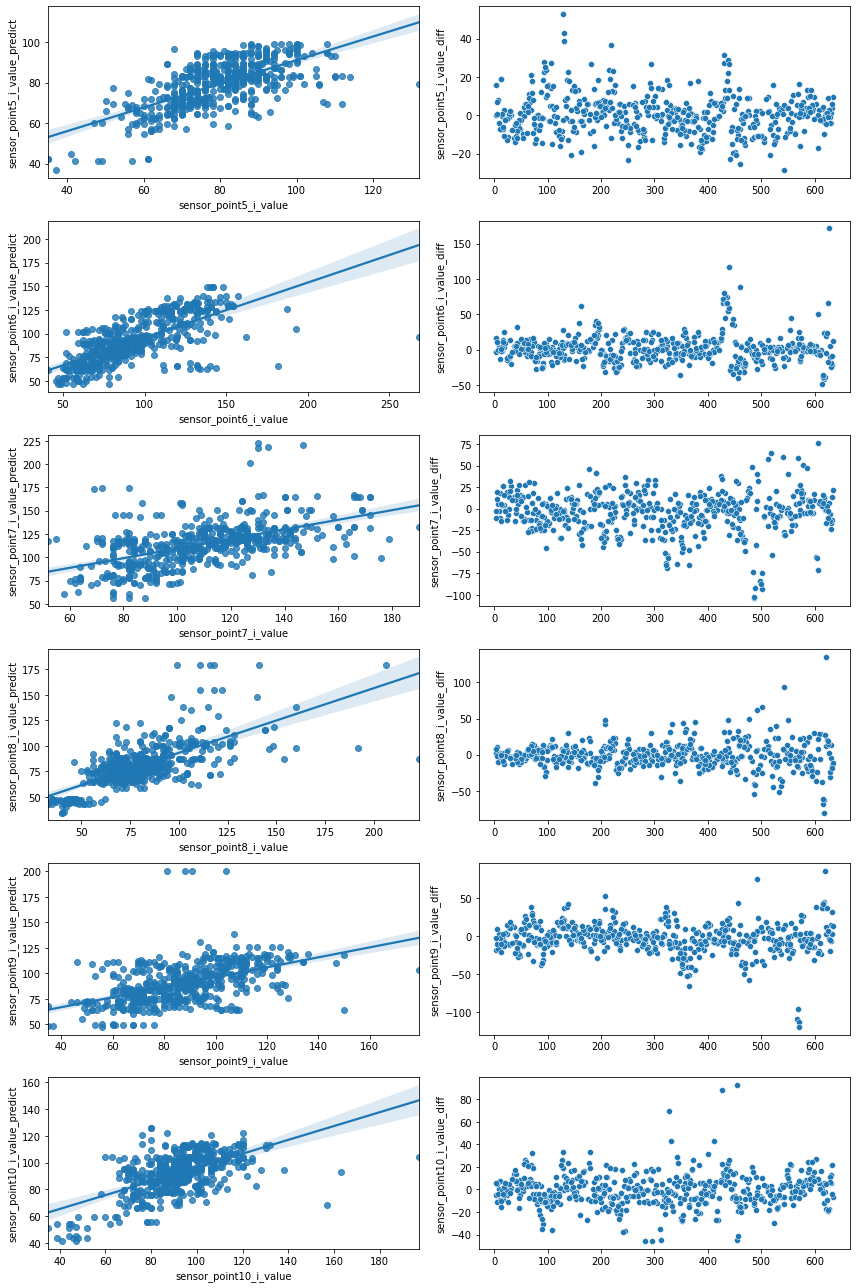

In [130]:
fig, axes = plt.subplots(6, 2, figsize=(12, 18))

for i in range(6):
    sns.regplot(x=Y_test.columns.tolist()[i], 
                y =Y_test.columns.tolist()[i] + '_predict', 
                data = Y_test_predict_diff, 
                ax=axes[i, 0])

    sns.scatterplot(x=Y_test_predict_diff.index,
                    y=Y_test.columns.tolist()[i] + '_diff',
                    data = Y_test_predict_diff, 
                    ax=axes[i, 1])
    
    
plt.tight_layout()

### Test：檢查MultiOutputRegressor跑出來的結果跟沒有用MultiOutputRegressor的結果是否有差異

In [50]:
wrapper = MultiOutputRegressor(poly_xgb_reg)
wrapper.fit(X_train, Y_train)
Y_predict_MO = wrapper.predict(X_train)
Y_predict_MO - Y_predict

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0.

### MixedRandomForest
*n_estimators(int)：森林中的樹木數量。可選的。默認值：10。

*max_features(int | float | str)：尋找最佳分割時要考慮的特徵數量。可選的。默認值：'sqrt'。
如果是 int，則在每次拆分時考慮 max_features 特徵。
如果是浮點數，那麼 max_features 是一個分數，並且在每次拆分時都會考慮 int(max_features * n_features) 個特徵。
如果“sqrt”，則 max_features=sqrt(n_features)（與“auto”相同）。
如果“log2”，則 max_features=log2(n_features)。
如果沒有，那麼 max_features=n_features。
注意：在找到至少一個節點樣本的有效分區之前，對拆分的搜索不會停止，即使它需要有效地檢查超過 max_features 個特徵。

*min_samples_leaf(int)：葉節點所需的最小樣本數。可選的。默認值：5。

注意：任何深度的分割點只有在左右分支中至少留下 min_samples_leaf 訓練樣本時才會被考慮。這可能具有平滑模型的效果，尤其是在回歸中。

*choose_split(str)：用於找到最佳分割的方法。可選的。默認值：“平均值”。

默認情況下，將使用平均信息增益。

可能的值：
'mean'：使用平均信息增益。
'max'：使用最大信息增益。
'random'：隨機選擇其中一個預測任務，並選擇其個體信息增益作為分割的信息增益。
classification_targets(int[])：屬於分類任務的特徵。可選的。默認值：無。

如果未指定分類目標，則隨機森林會將所有變量視為回歸變量。

In [ ]:
from morfist import MixedRandomForest

In [ ]:
cv_scores